In [10]:
import numpy as np
import torch
import cv2
import os
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from train_utils import *
from sklearn.metrics import jaccard_score

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
sam2_checkpoint = "./checkpoints/sam2.1_hiera_tiny.pt" # path to model weight (pre model loaded from: https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt)
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml" #  model config
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda") # load model
predictor = SAM2ImagePredictor(sam2_model)

In [22]:
build_dataset(name = 'datasets')

Current working directory: /home/stellarlane/main/finetune/sam2
clinicDB train: 581, val: 31
CVC-ColonDB train: 361, val: 19
ETIS train: 186, val: 10


In [ ]:
predictor.model.sam_mask_decoder.train(True) # enable training of mask decoder
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=1e-5,weight_decay=4e-5)
scaler = torch.amp.GradScaler('cuda')
losses = []
for itr in range(1000):
    with torch.amp.autocast('cuda'): # cast to mix precision
            image, mask, input_point, input_label = load_one_data("./dataset_0424/train/") # load data batch
            image = image.copy()
            mask = mask.copy()
            if mask.shape[0]==0: continue # ignore empty batches
            predictor.set_image(image) # apply SAM image encoder to the image

            # prompt encoding

            mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
            sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points=(unnorm_coords, labels),boxes=None,masks=None,)

            # mask decoder

            batched_mode = unnorm_coords.shape[0] > 1 # multi object prediction
            high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
            low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),sparse_prompt_embeddings=sparse_embeddings,dense_prompt_embeddings=dense_embeddings,multimask_output=True,repeat_image=batched_mode,high_res_features=high_res_features,)
            prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])# Upscale the masks to the original image resolution

            # Segmentaion Loss caclulation

            gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
            prd_mask = torch.sigmoid(prd_masks[:, 0])# Turn logit map to probability map
            seg_loss = (-gt_mask * torch.log(prd_mask + 0.00001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean() # cross entropy loss

            # Score loss calculation (intersection over union) IOU

            inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
            iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
            score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
            loss=seg_loss+score_loss*0.05  # mix losses

            # apply back propogation

            predictor.model.zero_grad() # empty gradient
            scaler.scale(loss).backward()  # Backpropogate
            scaler.step(optimizer)
            scaler.update() # Mix precision

            if itr%100==0: torch.save(predictor.model.state_dict(), "fined_tuned_1.pt")

            if itr==0: mean_iou=0
            mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
            losses.append(mean_iou)
            print("step)",itr, "Accuracy(IOU)=",mean_iou)

step) 0 Accuracy(IOU)= 0.00080545445
step) 1 Accuracy(IOU)= 0.001253562
step) 2 Accuracy(IOU)= 0.0037473207
step) 3 Accuracy(IOU)= 0.00379131
step) 4 Accuracy(IOU)= 0.0051054657
step) 5 Accuracy(IOU)= 0.0054662945
step) 6 Accuracy(IOU)= 0.006793735
step) 7 Accuracy(IOU)= 0.007097728
step) 8 Accuracy(IOU)= 0.010418125
step) 9 Accuracy(IOU)= 0.013497358
step) 10 Accuracy(IOU)= 0.015286694
step) 11 Accuracy(IOU)= 0.021160148
step) 12 Accuracy(IOU)= 0.02699656
step) 13 Accuracy(IOU)= 0.02802736
step) 14 Accuracy(IOU)= 0.028317405
step) 15 Accuracy(IOU)= 0.029403875
step) 16 Accuracy(IOU)= 0.029996987
step) 17 Accuracy(IOU)= 0.036266867
step) 18 Accuracy(IOU)= 0.043406494
step) 19 Accuracy(IOU)= 0.044831436
step) 20 Accuracy(IOU)= 0.052117467
step) 21 Accuracy(IOU)= 0.059388217
step) 22 Accuracy(IOU)= 0.06485813
step) 23 Accuracy(IOU)= 0.06699599
step) 24 Accuracy(IOU)= 0.07395413
step) 25 Accuracy(IOU)= 0.08156889
step) 26 Accuracy(IOU)= 0.08117528
step) 27 Accuracy(IOU)= 0.08219929
step) 

In [19]:
predictor.model.sam_mask_decoder.train(False) # enable training of mask decoder
predictor.model.sam_prompt_encoder.train(True)
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=1e-5,weight_decay=4e-5)
scaler = torch.amp.GradScaler('cuda')

losses = []
for itr in range(1000):
    with torch.amp.autocast('cuda'): # cast to mix precision
            image, mask, input_point, input_label = load_one_data("./dataset_0424/train/") # load data batch
            image = image.copy()
            mask = mask.copy()
            if mask.shape[0]==0: continue # ignore empty batches
            predictor.set_image(image) # apply SAM image encoder to the image

            # prompt encoding

            mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
            sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points=(unnorm_coords, labels),boxes=None,masks=None,)

            # mask decoder

            batched_mode = unnorm_coords.shape[0] > 1 # multi object prediction
            high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
            low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),sparse_prompt_embeddings=sparse_embeddings,dense_prompt_embeddings=dense_embeddings,multimask_output=True,repeat_image=batched_mode,high_res_features=high_res_features,)
            prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])# Upscale the masks to the original image resolution

            # Segmentaion Loss caclulation

            gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
            prd_mask = torch.sigmoid(prd_masks[:, 0])# Turn logit map to probability map
            seg_loss = (-gt_mask * torch.log(prd_mask + 0.00001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean() # cross entropy loss

            # Score loss calculation (intersection over union) IOU

            inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
            iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
            score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
            loss=seg_loss+score_loss*0.05  # mix losses

            # apply back propogation

            predictor.model.zero_grad() # empty gradient
            scaler.scale(loss).backward()  # Backpropogate
            scaler.step(optimizer)
            scaler.update() # Mix precision

            if itr%1==0: torch.save(predictor.model.state_dict(), "fined_tuned_2.pt")

            if itr==0: mean_iou=0
            mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
            losses.append(mean_iou)
            print("step)",itr, "Accuracy(IOU)=",mean_iou)

step) 0 Accuracy(IOU)= 0.0021474052
step) 1 Accuracy(IOU)= 0.007816679
step) 2 Accuracy(IOU)= 0.015189705
step) 3 Accuracy(IOU)= 0.024388188
step) 4 Accuracy(IOU)= 0.03089551
step) 5 Accuracy(IOU)= 0.037589036
step) 6 Accuracy(IOU)= 0.046174504
step) 7 Accuracy(IOU)= 0.054894127
step) 8 Accuracy(IOU)= 0.06383133
step) 9 Accuracy(IOU)= 0.07181365
step) 10 Accuracy(IOU)= 0.07978115
step) 11 Accuracy(IOU)= 0.0882038
step) 12 Accuracy(IOU)= 0.09635987
step) 13 Accuracy(IOU)= 0.101666495
step) 14 Accuracy(IOU)= 0.106629565
step) 15 Accuracy(IOU)= 0.11404679
step) 16 Accuracy(IOU)= 0.1136823
step) 17 Accuracy(IOU)= 0.121221945
step) 18 Accuracy(IOU)= 0.12307947
step) 19 Accuracy(IOU)= 0.1303133
step) 20 Accuracy(IOU)= 0.13595879
step) 21 Accuracy(IOU)= 0.14254808
step) 22 Accuracy(IOU)= 0.14945379
step) 23 Accuracy(IOU)= 0.15586773
step) 24 Accuracy(IOU)= 0.16171455
step) 25 Accuracy(IOU)= 0.16921112
step) 26 Accuracy(IOU)= 0.17484258
step) 27 Accuracy(IOU)= 0.1816291
step) 28 Accuracy(IOU)=

In [29]:
sam2_checkpoint = "./checkpoints/sam2.1_hiera_tiny.pt" # path to model weight (pre model loaded from: https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt)
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml" #  model config
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda") # load model
predictor_raw = SAM2ImagePredictor(sam2_model)
predictor_1 = SAM2ImagePredictor(sam2_model)
predictor_1.model.load_state_dict(torch.load("fined_tuned_1.pt")) # load fine tuned model
predictor_2 = SAM2ImagePredictor(sam2_model)
predictor_2.model.load_state_dict(torch.load("fined_tuned_2.pt")) # load fine tuned model

<All keys matched successfully>

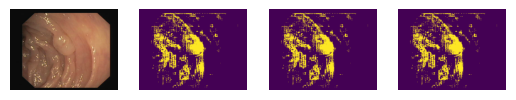

In [97]:
def compare(i):
    with torch.no_grad(): # prevent the net from caclulate gradient (more efficient inference)
            img, _, input_point, _ = load_one_data("./dataset_0424/val/") # load data batch
            predictor_1.set_image(Image.fromarray(img)) # image encoder
            masks_1, scores_1, logits_1 = predictor_1.predict(
                #   point_coords=input_point, 
                #   point_labels=np.ones(len(input_point))
                  )
            predictor_2.set_image(Image.fromarray(img))
            masks_2, scores_2, logits_2 = predictor_2.predict(
                #   point_coords=input_point, 
                #   point_labels=np.ones(len(input_point))
                  )
            predictor_raw.set_image(Image.fromarray(img))
            masks_raw, scores_raw, logits_raw = predictor_raw.predict(
                #   point_coords=input_point, 
                #   point_labels=np.ones(len(input_point))
                  ) # predict masks
            
            plt.subplot(1, 4, 1)
            plt.imshow(img)
            plt.axis('off')
            plt.subplot(1, 4, 2)
            plt.imshow(masks_1[0])
            plt.axis('off')
            plt.subplot(1, 4, 3)
            plt.imshow(masks_2[0])
            plt.axis('off')
            plt.subplot(1, 4, 4)
            plt.imshow(masks_raw[0])
            plt.axis('off')

i=1
compare(i)

In [ ]:
import matplotlib.pyplot as plt

# Set the image you want to predict on (here we use the variable 'img' already available)
predictor.set_image(img)

# Use the predictor's predict method with prompt inputs (using input_point and input_label)
# This returns predicted masks, scores, and logits.
pred_masks, pred_scores, _ = predictor.predict(
    points=input_point,
    labels=input_label,
    multimask_output=True
)

# Visualize the first predicted mask overlayed on the original image
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.imshow(pred_masks[0].cpu().detach().numpy(), alpha=0.5, cmap='jet')
plt.title("Predicted Mask")
plt.show()

In [1]:
img, masks, points, labels = load_one_data()
plt.imshow(img)
plt.imshow(masks[0], alpha=1)

import pandas as pd
df = pd.DataFrame(masks[0])
plt.scatter(points[0][0], points[0][1], c='r', s=10)
plt.axis('off')

NameError: name 'load_one_data' is not defined